## Step 1: Install Required Packages

First, we need to install CrewAI and its dependencies. We'll use:
- `crewai`: The main framework
- `crewai-tools`: Pre-built tools for agents

In [68]:
# Install required packages
!pip install -q crewai crewai-tools


[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: C:\Users\edvard.smoliakov\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


## Step 2: Setup API Keys and Environment

To use OpenAI's GPT-4.1-mini model, you need an API key and base URL.

**Security Best Practice:** Store your API key in a `.env` file, not in the code!

In [69]:
import getpass
import os

if "OPENAI_API_KEY" not in os.environ:
    os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API Key: ")

if "OPENAI_BASE_URL" not in os.environ:
    os.environ["OPENAI_BASE_URL"] = getpass.getpass("Enter your OpenAI Base URL: ")

## Step 3: Create Custom Tools

Tools are functions that agents can use to perform specific tasks. Let's create custom tools for our movie production assistant.

### Tool 1: Script Sentiment Analyzer
Analyzes the emotional tone of a script excerpt.

In [70]:
from crewai.tools import tool
import re

@tool("Script Sentiment Analyzer")
def analyze_script_sentiment(script_text: str) -> str:
    """
    Analyzes the sentiment and emotional tone of a movie script excerpt.
    Returns sentiment score and dominant emotions.

    Args:
        script_text: A string containing the script excerpt to analyze
    """
    # Simple sentiment analysis based on keywords
    positive_words = ['love', 'happy', 'joy', 'wonderful', 'amazing', 'brilliant', 'triumph', 'success']
    negative_words = ['hate', 'sad', 'angry', 'terrible', 'awful', 'tragedy', 'failure', 'death']
    suspense_words = ['mystery', 'unknown', 'hidden', 'secret', 'suspense', 'thriller']

    script_lower = script_text.lower()

    pos_count = sum(1 for word in positive_words if word in script_lower)
    neg_count = sum(1 for word in negative_words if word in script_lower)
    sus_count = sum(1 for word in suspense_words if word in script_lower)

    total = pos_count + neg_count + sus_count

    if total == 0:
        return "Sentiment: Neutral - No strong emotional indicators detected."

    result = f"Sentiment Analysis Results:\n"
    result += f"- Positive tone: {pos_count}/{total} ({pos_count/total*100:.1f}%)\n"
    result += f"- Negative tone: {neg_count}/{total} ({neg_count/total*100:.1f}%)\n"
    result += f"- Suspenseful tone: {sus_count}/{total} ({sus_count/total*100:.1f}%)\n"

    if pos_count > neg_count and pos_count > sus_count:
        result += "\nOverall: Uplifting and positive story"
    elif neg_count > pos_count and neg_count > sus_count:
        result += "\nOverall: Dark and dramatic narrative"
    else:
        result += "\nOverall: Tense and mysterious atmosphere"

    return result

# Test the tool
test_script = "A tale of love and triumph as Sarah discovers the hidden mystery that brings her joy."
print(analyze_script_sentiment.run(test_script))

Sentiment Analysis Results:
- Positive tone: 3/5 (60.0%)
- Negative tone: 0/5 (0.0%)
- Suspenseful tone: 2/5 (40.0%)

Overall: Uplifting and positive story


### Tool 2: Budget Calculator
Calculates production costs based on different categories.

In [71]:
@tool("Production Budget Calculator")
def calculate_production_budget(category: str, days: int = 30, crew_size: int = 50) -> str:
    """
    Calculates estimated production budget for different movie categories.

    Args:
        category: Type of production (indie, medium, blockbuster)
        days: Number of shooting days
        crew_size: Number of crew members
    """
    # Base daily rates per category
    rates = {
        'indie': {'daily': 50000, 'crew': 500, 'equipment': 10000},
        'medium': {'daily': 200000, 'crew': 2000, 'equipment': 50000},
        'blockbuster': {'daily': 1000000, 'crew': 10000, 'equipment': 250000}
    }

    category = category.lower()
    if category not in rates:
        return f"Unknown category. Choose from: {', '.join(rates.keys())}"

    rate = rates[category]

    production_cost = rate['daily'] * days
    crew_cost = rate['crew'] * crew_size * days
    equipment_cost = rate['equipment'] * days
    contingency = (production_cost + crew_cost + equipment_cost) * 0.15

    total = production_cost + crew_cost + equipment_cost + contingency

    result = f"📊 Budget Breakdown for {category.upper()} Production:\n"
    result += f"\n🎬 Production Costs: ${production_cost:,}"
    result += f"\n👥 Crew Costs ({crew_size} members): ${crew_cost:,}"
    result += f"\n📹 Equipment Rental: ${equipment_cost:,}"
    result += f"\n🛡️ Contingency (15%): ${contingency:,}"
    result += f"\n\n💰 TOTAL ESTIMATED BUDGET: ${total:,}"
    result += f"\n📅 For {days} shooting days"

    return result

# Test the tool
print(calculate_production_budget.run("medium", days=45, crew_size=75))

📊 Budget Breakdown for MEDIUM Production:

🎬 Production Costs: $9,000,000
👥 Crew Costs (75 members): $6,750,000
📹 Equipment Rental: $2,250,000
🛡️ Contingency (15%): $2,700,000.0

💰 TOTAL ESTIMATED BUDGET: $20,700,000.0
📅 For 45 shooting days


### Tool 3: Soundtrack Genre Recommender
Suggests music genres based on the movie's theme and mood.

In [72]:
@tool("Soundtrack Genre Recommender")
def recommend_soundtrack_genre(movie_genre: str, mood: str) -> str:
    """
    Recommends soundtrack genres based on movie genre and mood.

    Args:
        movie_genre: The genre of the movie (action, drama, comedy, horror, sci-fi, romance)
        mood: The desired mood (intense, light, emotional, mysterious, upbeat)
    """
    recommendations = {
        'action': {
            'intense': ['Epic Orchestral', 'Electronic/Synth', 'Heavy Metal'],
            'light': ['Pop Rock', 'Funk', 'Electronic Pop'],
            'emotional': ['Cinematic Strings', 'Piano & Strings', 'Alternative Rock'],
        },
        'drama': {
            'intense': ['Classical', 'Dramatic Orchestral', 'Jazz Noir'],
            'emotional': ['Piano Solo', 'String Quartet', 'Acoustic Guitar'],
            'mysterious': ['Ambient', 'Minimalist Piano', 'Contemporary Classical'],
        },
        'comedy': {
            'upbeat': ['Jazz', 'Pop', 'Ska', 'Funk'],
            'light': ['Acoustic Pop', 'Ukulele', 'Whistling & Bells'],
        },
        'horror': {
            'intense': ['Dark Ambient', 'Industrial', 'Atonal Orchestral'],
            'mysterious': ['Theremin', 'Dissonant Strings', 'Electronic Drone'],
        },
        'sci-fi': {
            'intense': ['Electronic/Synth', 'Cyberpunk', 'Orchestral Hybrid'],
            'mysterious': ['Ambient Electronic', 'Experimental', 'Synth Pad'],
        },
        'romance': {
            'emotional': ['Classical Piano', 'Acoustic', 'Indie Folk'],
            'light': ['Soft Pop', 'Bossa Nova', 'Acoustic Guitar'],
            'upbeat': ['Pop', 'Soul', 'Light Jazz'],
        }
    }

    genre = movie_genre.lower()
    mood_key = mood.lower()

    if genre not in recommendations:
        return f"Unknown genre. Try: {', '.join(recommendations.keys())}"

    genre_moods = recommendations[genre]
    if mood_key not in genre_moods:
        return f"For {genre}, available moods are: {', '.join(genre_moods.keys())}"

    suggested = genre_moods[mood_key]

    result = f"🎵 Soundtrack Recommendations for {genre.upper()} ({mood} mood):\n\n"
    for i, genre_rec in enumerate(suggested, 1):
        result += f"{i}. {genre_rec}\n"

    result += f"\n💡 Tip: Consider mixing {suggested[0]} with {suggested[-1]} for dynamic scenes!"

    return result

# Test the tool
print(recommend_soundtrack_genre.run("sci-fi", "mysterious"))

🎵 Soundtrack Recommendations for SCI-FI (mysterious mood):

1. Ambient Electronic
2. Experimental
3. Synth Pad

💡 Tip: Consider mixing Ambient Electronic with Synth Pad for dynamic scenes!


## Step 4: Integrate MCP Tool (Model Context Protocol)

MCP tools allow agents to interact with external systems and APIs. Here we'll create a simulated MCP tool for accessing a movie database.

**Note:** In production, MCP tools connect to real external services. This is a simplified demonstration.

In [73]:
from typing import Dict, Any

@tool("Movie Market Research MCP")
def fetch_market_data(genre: str) -> str:
    """
    Fetches market research data for a specific movie genre from the database.
    This simulates an MCP tool that connects to external market research APIs.

    Args:
        genre: The movie genre to research (action, drama, comedy, horror, sci-fi, romance)
    """
    # Simulated market data (in production, this would call a real API)
    market_database = {
        'action': {
            'avg_box_office': '$450M',
            'audience_demographic': '18-35 years, 65% male',
            'peak_season': 'Summer (May-August)',
            'trending_themes': ['Superheroes', 'International espionage', 'Disaster scenarios'],
            'streaming_performance': 'High - 85% completion rate',
        },
        'drama': {
            'avg_box_office': '$120M',
            'audience_demographic': '30-60 years, 55% female',
            'peak_season': 'Awards season (October-February)',
            'trending_themes': ['Social justice', 'Biography', 'Family dynamics'],
            'streaming_performance': 'Medium - 72% completion rate',
        },
        'comedy': {
            'avg_box_office': '$180M',
            'audience_demographic': '18-45 years, balanced gender',
            'peak_season': 'Year-round, slight spike in holidays',
            'trending_themes': ['Romantic comedy', 'Workplace humor', 'Cultural clash'],
            'streaming_performance': 'Very High - 90% completion rate',
        },
        'horror': {
            'avg_box_office': '$95M',
            'audience_demographic': '16-30 years, 52% male',
            'peak_season': 'Fall (September-November)',
            'trending_themes': ['Psychological horror', 'Folk horror', 'Home invasion'],
            'streaming_performance': 'High - 82% completion rate',
        },
        'sci-fi': {
            'avg_box_office': '$380M',
            'audience_demographic': '18-40 years, 60% male',
            'peak_season': 'Summer and Holiday season',
            'trending_themes': ['AI & technology', 'Space exploration', 'Time travel'],
            'streaming_performance': 'High - 88% completion rate',
        },
        'romance': {
            'avg_box_office': '$85M',
            'audience_demographic': '18-50 years, 70% female',
            'peak_season': 'Valentine\'s Day season (January-February)',
            'trending_themes': ['Second chance romance', 'Holiday romance', 'Cross-cultural love'],
            'streaming_performance': 'Very High - 92% completion rate',
        },
    }

    genre_key = genre.lower()

    if genre_key not in market_database:
        return f"❌ No market data available for '{genre}'. Available genres: {', '.join(market_database.keys())}"

    data = market_database[genre_key]

    result = f"📈 Market Research Report: {genre.upper()} Genre\n"
    result += f"\n💰 Average Box Office: {data['avg_box_office']}"
    result += f"\n👥 Target Demographic: {data['audience_demographic']}"
    result += f"\n📅 Best Release Window: {data['peak_season']}"
    result += f"\n🎬 Trending Themes:"
    for theme in data['trending_themes']:
        result += f"\n   • {theme}"
    result += f"\n📺 Streaming Performance: {data['streaming_performance']}"
    result += f"\n\n✅ Data retrieved from Market Intelligence Database (MCP)"

    return result

# Test the MCP tool
print(fetch_market_data.run("action"))

📈 Market Research Report: ACTION Genre

💰 Average Box Office: $450M
👥 Target Demographic: 18-35 years, 65% male
📅 Best Release Window: Summer (May-August)
🎬 Trending Themes:
   • Superheroes
   • International espionage
   • Disaster scenarios
📺 Streaming Performance: High - 85% completion rate

✅ Data retrieved from Market Intelligence Database (MCP)


## Step 5: Configure the Language Model

Now let's set up OpenAI's GPT-4.1-mini model to power our agents. This model is fast and cost-effective, perfect for agent-based workflows.

In [74]:
from crewai import LLM

# Initialize GPT-4.1-mini using CrewAI's LLM wrapper
llm = LLM(
    model="openai/gpt-4.1-mini",
    api_key=os.environ["OPENAI_API_KEY"],
    base_url=os.environ["OPENAI_BASE_URL"],
    temperature=0.7,  # Controls creativity (0=focused, 1=creative)
)

print("✅ Language model configured: GPT-4.1-mini")
print("   - Model: openai/gpt-4.1-mini")
print("   - Temperature: 0.7 (balanced creativity)")

✅ Language model configured: GPT-4.1-mini
   - Model: openai/gpt-4.1-mini
   - Temperature: 0.7 (balanced creativity)


## Step 6: Create Specialized Agents

Agents are AI assistants with specific roles and tools. Let's create a crew of specialized agents for movie production:

1. **Script Analyst** - Analyzes scripts and provides creative feedback
2. **Budget Manager** - Handles financial planning and budgeting
3. **Market Researcher** - Provides market insights and recommendations

In [75]:
from crewai import Agent

# Agent 1: Script Analyst
script_analyst = Agent(
    role="Script Analyst",
    goal="Analyze movie scripts for sentiment, themes, and recommend appropriate soundtracks",
    backstory="""You are an experienced script analyst with 15 years in Hollywood.
    You have a keen eye for emotional depth and understand how music enhances storytelling.
    You've worked on numerous award-winning films and know what makes a script compelling.""",
    tools=[analyze_script_sentiment, recommend_soundtrack_genre],
    llm=llm,
    verbose=True,  # Shows detailed thinking process
    allow_delegation=False,  # Can't delegate tasks to other agents
)

# Agent 2: Budget Manager
budget_manager = Agent(
    role="Production Budget Manager",
    goal="Calculate accurate production budgets and optimize spending across departments",
    backstory="""You are a meticulous financial expert specializing in film production.
    With an MBA and 10 years of experience managing budgets for indie to blockbuster films,
    you ensure projects stay financially viable while maintaining creative vision.""",
    tools=[calculate_production_budget],
    llm=llm,
    verbose=True,
    allow_delegation=False,
)

# Agent 3: Market Researcher
market_researcher = Agent(
    role="Film Market Research Analyst",
    goal="Provide data-driven insights about market trends, audience preferences, and optimal release strategies",
    backstory="""You are a data scientist specializing in entertainment industry analytics.
    You analyze box office trends, streaming data, and audience demographics to help studios
    make informed decisions about production and distribution.""",
    tools=[fetch_market_data],
    llm=llm,
    verbose=True,
    allow_delegation=False,
)

print("✅ Created 3 specialized agents:")
print("   1. Script Analyst (sentiment & soundtrack)")
print("   2. Budget Manager (financial planning)")
print("   3. Market Researcher (market intelligence)")

✅ Created 3 specialized agents:
   1. Script Analyst (sentiment & soundtrack)
   2. Budget Manager (financial planning)
   3. Market Researcher (market intelligence)


## Step 7: Define Tasks for Agents

Tasks are specific assignments given to agents. Each task has:
- A clear description
- An assigned agent
- Expected output format

In [76]:
from crewai import Task

# Sample movie concept for our tasks
movie_concept = """
Title: "Echoes of Tomorrow"
Genre: Sci-Fi Thriller
Logline: A brilliant AI researcher discovers a hidden message in quantum data that reveals
humanity's tragic future. Racing against time and a mysterious organization, she must decide
whether to alter the timeline or accept humanity's fate.

Script Excerpt: "In the depths of the unknown laboratory, Sarah's discovery brings both
triumph and terror. The hidden secret she uncovers could save millions, but the mystery
of who left this message haunts her every waking moment."
"""

# Task 1: Analyze the script
task_analyze_script = Task(
    description=f"""Analyze the following movie concept and script excerpt:

    {movie_concept}

    Use your tools to:
    1. Analyze the sentiment of the script excerpt
    2. Recommend appropriate soundtrack genres based on the genre and mood
    3. Provide creative suggestions for enhancing the emotional impact
    """,
    expected_output="A detailed analysis including sentiment breakdown, soundtrack recommendations, and creative suggestions",
    agent=script_analyst,
)

# Task 2: Calculate budget
task_budget_calculation = Task(
    description="""Based on the sci-fi thriller movie concept, calculate the production budget.

    Assume:
    - This is a MEDIUM budget production
    - 60 days of shooting
    - Crew size of 85 people

    Provide a detailed breakdown and recommendations for budget optimization.
    """,
    expected_output="Complete budget breakdown with optimization recommendations",
    agent=budget_manager,
)

# Task 3: Market research
task_market_research = Task(
    description="""Conduct market research for the sci-fi thriller genre.

    Use the MCP tool to fetch market data and provide:
    1. Current market performance of sci-fi films
    2. Target audience insights
    3. Optimal release timing
    4. Strategic recommendations based on trending themes
    """,
    expected_output="Comprehensive market analysis with strategic release recommendations",
    agent=market_researcher,
)

print("✅ Created 3 tasks:")
print("   1. Script Analysis Task")
print("   2. Budget Calculation Task")
print("   3. Market Research Task")

✅ Created 3 tasks:
   1. Script Analysis Task
   2. Budget Calculation Task
   3. Market Research Task


## Step 8: Assemble the Crew and Execute

Now we bring it all together! A Crew coordinates multiple agents working on related tasks.

**Process Types:**
- `sequential`: Tasks execute one after another (used here)
- `hierarchical`: A manager agent coordinates other agents

In [ ]:
from crewai import Crew, Process

# Assemble the crew
movie_production_crew = Crew(
    agents=[script_analyst, budget_manager, market_researcher],
    tasks=[task_analyze_script, task_budget_calculation, task_market_research],
    process=Process.sequential,  # Tasks run in order
    verbose=True,  # Enable detailed output for learning
)

print("✅ Crew assembled with 3 agents and 3 tasks")
print("\n🚀 Starting production analysis...\n")
print("=" * 80)

# Execute the crew's tasks
result = movie_production_crew.kickoff()

print("\n" + "=" * 80)
print("\n✅ Analysis Complete!\n")

✅ Crew assembled with 3 agents and 3 tasks

🚀 Starting production analysis...



╭─────────────────────────────────────────── 🚀 Crew Execution Started ───────────────────────────────────────────╮
│                                                                                                                 │
│  Crew Execution Started                                                                                         │
│  Name:                                                                                                          │
│  crew                                                                                                           │
│  ID:                                                                                                            │
│  06f45977-38ab-43fe-bb0c-a53d72c7da01                                                                           │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 📋 Task Started ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Task Started                                                                                                   │
│  Name: Analyze the following movie concept and script excerpt:                                                  │
│                                                                                                                 │
│                                                                                                                 │
│  Title: "Echoes of Tomorrow"                                                                                    │
│  Genre: Sci-Fi Thriller                                                                                         │
│  Logline: A brilliant AI researcher discovers a hidden message in quantum data that reveals                     │
│  humanity's tragic future. Racing against time and a mysterious organization, she must decide                   │
│  whether to alter the timeline or accept humanity's fate.                                                       │
│                                                                                                                 │
│  Script Excerpt: "In the depths of the unknown laboratory, Sarah's discovery brings both                        │
│  triumph and terror. The hidden secret she uncovers could save millions, but the mystery                        │
│  of who left this message haunts her every waking moment."                                                      │
│                                                                                                                 │
│                                                                                                                 │
│      Use your tools to:                                                                                         │
│      1. Analyze the sentiment of the script excerpt                                                             │
│      2. Recommend appropriate soundtrack genres based on the genre and mood                                     │
│      3. Provide creative suggestions for enhancing the emotional impact                                         │
│                                                                                                                 │
│  ID: 0502c673-f3c8-4b3a-affb-da0c911ce577                                                                       │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────── 🤖 Agent Started ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Agent: Script Analyst                                                                                          │
│                                                                                                                 │
│  Task: Analyze the following movie concept and script excerpt:                                                  │
│                                                                                                                 │
│                                                                                                                 │
│  Title: "Echoes of Tomorrow"                                                                                    │
│  Genre: Sci-Fi Thriller                                                                                         │
│  Logline: A brilliant AI researcher discovers a hidden message in quantum data that reveals                     │
│  humanity's tragic future. Racing against time and a mysterious organization, she must decide                   │
│  whether to alter the timeline or accept humanity's fate.                                                       │
│                                                                                                                 │
│  Script Excerpt: "In the depths of the unknown laboratory, Sarah's discovery brings both                        │
│  triumph and terror. The hidden secret she uncovers could save millions, but the mystery                        │
│  of who left this message haunts her every waking moment."                                                      │
│                                                                                                                 │
│                                                                                                                 │
│      Use your tools to:                                                                                         │
│      1. Analyze the sentiment of the script excerpt                                                             │
│      2. Recommend appropriate soundtrack genres based on the genre and mood                                     │
│      3. Provide creative suggestions for enhancing the emotional impact                                         │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Tool script_sentiment_analyzer executed with result: Sentiment Analysis Results:
- Positive tone: 1/5 (20.0%)
- Negative tone: 0/5 (0.0%)
- Suspenseful tone: 4/5 (80.0%)

Overall: Tense and mysterious atmosphere...


╭──────────────────────────────────────── 🔧 Tool Execution Started (#5) ─────────────────────────────────────────╮
│                                                                                                                 │
│  Tool: script_sentiment_analyzer                                                                                │
│  Args: {'script_text': "In the depths of the unknown laboratory, Sarah's discovery brings both triumph and      │
│  terror. The hidden secret she uncovers could save millions, but the mystery of who left this message...        │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────── ✅ Tool Execution Completed (#5) ────────────────────────────────────────╮
│                                                                                                                 │
│  Tool Completed                                                                                                 │
│  Tool: script_sentiment_analyzer                                                                                │
│  Output: Sentiment Analysis Results:                                                                            │
│  - Positive tone: 1/5 (20.0%)                                                                                   │
│  - Negative tone: 0/5 (0.0%)                                                                                    │
│  - Suspenseful tone: 4/5 (80.0%)                                                                                │
│                                                                                                                 │
│  Overall: Tense and mysterious atmosphere                                                                       │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Tool soundtrack_genre_recommender executed with result: Unknown genre. Try: action, drama, comedy, horror, sci-fi, romance...


╭──────────────────────────────────────── 🔧 Tool Execution Started (#7) ─────────────────────────────────────────╮
│                                                                                                                 │
│  Tool: soundtrack_genre_recommender                                                                             │
│  Args: {'movie_genre': 'sci-fi thriller', 'mood': 'intense'}                                                    │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────── ✅ Tool Execution Completed (#7) ────────────────────────────────────────╮
│                                                                                                                 │
│  Tool Completed                                                                                                 │
│  Tool: soundtrack_genre_recommender                                                                             │
│  Output: Unknown genre. Try: action, drama, comedy, horror, sci-fi, romance                                     │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Tool soundtrack_genre_recommender executed with result: 🎵 Soundtrack Recommendations for SCI-FI (intense mood):

1. Electronic/Synth
2. Cyberpunk
3. Orchestral Hybrid

💡 Tip: Consider mixing Electronic/Synth with Orchestral Hybrid for dynamic scenes!...


╭──────────────────────────────────────── 🔧 Tool Execution Started (#8) ─────────────────────────────────────────╮
│                                                                                                                 │
│  Tool: soundtrack_genre_recommender                                                                             │
│  Args: {'movie_genre': 'sci-fi', 'mood': 'intense'}                                                             │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────── ✅ Tool Execution Completed (#8) ────────────────────────────────────────╮
│                                                                                                                 │
│  Tool Completed                                                                                                 │
│  Tool: soundtrack_genre_recommender                                                                             │
│  Output: 🎵 Soundtrack Recommendations for SCI-FI (intense mood):                                               │
│                                                                                                                 │
│  1. Electronic/Synth                                                                                            │
│  2. Cyberpunk                                                                                                   │
│  3. Orchestral Hybrid                                                                                           │
│                                                                                                                 │
│  💡 Tip: Consider mixing Electronic/Synth with Orchestral Hybrid for dynamic scenes!                            │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────── ✅ Agent Final Answer ─────────────────────────────────────────────╮
│                                                                                                                 │
│  Agent: Script Analyst                                                                                          │
│                                                                                                                 │
│  Final Answer:                                                                                                  │
│  Detailed Analysis of "Echoes of Tomorrow":                                                                     │
│                                                                                                                 │
│  Sentiment Breakdown:                                                                                           │
│  The script excerpt carries a predominantly suspenseful and tense tone (80%) with hints of positive undertones  │
│  (20%). The mood is charged with mystery and urgency, reflecting both the triumph of Sarah's discovery and the  │
│  terror of the unknown consequences. The emotional tension is built around the stakes of saving millions and    │
│  the haunting mystery of the message's origin.                                                                  │
│                                                                                                                 │
│  Soundtrack Recommendations:                                                                                    │
│  For this sci-fi thriller with an intense mood, the following soundtrack genres are recommended:                │
│  1. Electronic/Synth – to evoke the futuristic and technological aspects of the story.                          │
│  2. Cyberpunk – to emphasize the dark, edgy, and mysterious atmosphere.                                         │
│  3. Orchestral Hybrid – to add dramatic weight and emotional depth in key moments.                              │
│                                                                                                                 │
│  A blend of Electronic/Synth with Orchestral Hybrid can create a dynamic and immersive soundscape that          │
│  enhances both the tension and emotional resonance of the film.                                                 │
│                                                                                                                 │
│  Creative Suggestions for Enhancing Emotional Impact:                                                           │
│  1. Use a recurring musical motif associated with the hidden message, gradually revealing its complexity as     │
│  Sarah uncovers more clues.                                                                                     │
│  2. Employ contrasting sound design—sterile, mechanical sounds in the laboratory juxtaposed with warmer, more   │
│  organic instruments during moments of human vulnerability.                                                     │
│  3. Heighten suspense through silence or minimalistic scoring right before major revelations or plot twists.    │
│  4. Visually and sonically emphasize the duality of triumph and terror by alternating between uplifting         │
│  harmonies and dissonant tones in scenes depicting Sarah’s discovery.                                           │
│  5. Integrate subtle audio cues that hint at the mysterious organization’s presence, building an undercurrent   │
│  of paranoia and urgency.                                                                                       │
│                                                                                                                 │
│  This approach will deepen the audience's emotional engagement, complementing the script's themes of fate,      │
│  discovery, and moral dilemma within the sci-fi thrille

╭────────────────────────────────────────────── 📋 Task Completion ───────────────────────────────────────────────╮
│                                                                                                                 │
│  Task Completed                                                                                                 │
│  Name:                                                                                                          │
│  Analyze the following movie concept and script excerpt:                                                        │
│                                                                                                                 │
│                                                                                                                 │
│  Title: "Echoes of Tomorrow"                                                                                    │
│  Genre: Sci-Fi Thriller                                                                                         │
│  Logline: A brilliant AI researcher discovers a hidden message in quantum data that reveals                     │
│  humanity's tragic future. Racing against time and a mysterious organization, she must decide                   │
│  whether to alter the timeline or accept humanity's fate.                                                       │
│                                                                                                                 │
│  Script Excerpt: "In the depths of the unknown laboratory, Sarah's discovery brings both                        │
│  triumph and terror. The hidden secret she uncovers could save millions, but the mystery                        │
│  of who left this message haunts her every waking moment."                                                      │
│                                                                                                                 │
│                                                                                                                 │
│      Use your tools to:                                                                                         │
│      1. Analyze the sentiment of the script excerpt                                                             │
│      2. Recommend appropriate soundtrack genres based on the genre and mood                                     │
│      3. Provide creative suggestions for enhancing the emotional impact                                         │
│                                                                                                                 │
│  Agent:                                                                                                         │
│  Script Analyst                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 📋 Task Started ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Task Started                                                                                                   │
│  Name: Based on the sci-fi thriller movie concept, calculate the production budget.                             │
│                                                                                                                 │
│      Assume:                                                                                                    │
│      - This is a MEDIUM budget production                                                                       │
│      - 60 days of shooting                                                                                      │
│      - Crew size of 85 people                                                                                   │
│                                                                                                                 │
│      Provide a detailed breakdown and recommendations for budget optimization.                                  │
│                                                                                                                 │
│  ID: e6888b26-668a-4501-9403-9a8e426fa767                                                                       │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────── 🤖 Agent Started ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Agent: Production Budget Manager                                                                               │
│                                                                                                                 │
│  Task: Based on the sci-fi thriller movie concept, calculate the production budget.                             │
│                                                                                                                 │
│      Assume:                                                                                                    │
│      - This is a MEDIUM budget production                                                                       │
│      - 60 days of shooting                                                                                      │
│      - Crew size of 85 people                                                                                   │
│                                                                                                                 │
│      Provide a detailed breakdown and recommendations for budget optimization.                                  │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Tool production_budget_calculator executed with result: 📊 Budget Breakdown for MEDIUM Production:

🎬 Production Costs: $12,000,000
👥 Crew Costs (85 members): $10,200,000
📹 Equipment Rental: $3,000,000
🛡️ Contingency (15%): $3,780,000.0

💰 TOTAL ESTIMATED B...

╭──────────────────────────────────────── 🔧 Tool Execution Started (#3) ─────────────────────────────────────────╮
│                                                                                                                 │
│  Tool: production_budget_calculator                                                                             │
│  Args: {'category': 'medium', 'days': 60, 'crew_size': 85}                                                      │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────── ✅ Tool Execution Completed (#3) ────────────────────────────────────────╮
│                                                                                                                 │
│  Tool Completed                                                                                                 │
│  Tool: production_budget_calculator                                                                             │
│  Output: 📊 Budget Breakdown for MEDIUM Production:                                                             │
│                                                                                                                 │
│  🎬 Production Costs: $12,000,000                                                                               │
│  👥 Crew Costs (85 members): $10,200,000                                                                        │
│  📹 Equipment Rental: $3,000,000                                                                                │
│  🛡️ Contingency (15%): $3,780,000.0                                                                             │
│                                                                                                                 │
│  💰 TOTAL ESTIMATED BUDGET: $28,980,000.0                                                                       │
│  📅 For 60 shooting days                                                                                        │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────── ✅ Agent Final Answer ─────────────────────────────────────────────╮
│                                                                                                                 │
│  Agent: Production Budget Manager                                                                               │
│                                                                                                                 │
│  Final Answer:                                                                                                  │
│  Final Answer:                                                                                                  │
│                                                                                                                 │
│  Complete Budget Breakdown for "Echoes of Tomorrow" (Medium Budget Sci-Fi Thriller):                            │
│                                                                                                                 │
│  1. Production Costs: $12,000,000                                                                               │
│     - Includes set design, special effects, props, location fees, transportation, and other essential           │
│  production expenses.                                                                                           │
│                                                                                                                 │
│  2. Crew Costs (85 members): $10,200,000                                                                        │
│     - Salaries and wages for the crew, including technical staff, camera operators, lighting technicians,       │
│  production assistants, and other personnel.                                                                    │
│                                                                                                                 │
│  3. Equipment Rental: $3,000,000                                                                                │
│     - Costs for renting cameras, lighting, sound equipment, and other necessary gear to support high-quality    │
│  filming.                                                                                                       │
│                                                                                                                 │
│  4. Contingency (15% of total budget): $3,780,000                                                               │
│     - Reserved fund to cover unexpected expenses, schedule changes, or emergencies during production.           │
│                                                                                                                 │
│  Total Estimated Budget: $28,980,000 for 60 shooting days.                                                      │
│                                                                                                                 │
│  Budget Optimization Recommendations:                                                                           │
│  - Streamline Crew Size: Evaluate if all 85 crew members are essential. Reducing crew by even 10% could save    │
│  significant salary costs without compromising quality.                                                         │
│  - Equipment Sharing: Negotiate package deals with rental companies or use multi-purpose equipment to reduce    │
│  rental expenses.                                                                                               │
│  - Efficient Scheduling: Minimize shooting days by detailed planning to reduce daily costs related to crew and  │
│  location.                                                                                                      │
│  - Contingency Management: Monitor spending closely to avoid overshooting the contingency fund; reallocate      │
│  unused contingency to critical departments if needed. 

╭────────────────────────────────────────────── 📋 Task Completion ───────────────────────────────────────────────╮
│                                                                                                                 │
│  Task Completed                                                                                                 │
│  Name:                                                                                                          │
│  Based on the sci-fi thriller movie concept, calculate the production budget.                                   │
│                                                                                                                 │
│      Assume:                                                                                                    │
│      - This is a MEDIUM budget production                                                                       │
│      - 60 days of shooting                                                                                      │
│      - Crew size of 85 people                                                                                   │
│                                                                                                                 │
│      Provide a detailed breakdown and recommendations for budget optimization.                                  │
│                                                                                                                 │
│  Agent:                                                                                                         │
│  Production Budget Manager                                                                                      │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 📋 Task Started ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Task Started                                                                                                   │
│  Name: Conduct market research for the sci-fi thriller genre.                                                   │
│                                                                                                                 │
│      Use the MCP tool to fetch market data and provide:                                                         │
│      1. Current market performance of sci-fi films                                                              │
│      2. Target audience insights                                                                                │
│      3. Optimal release timing                                                                                  │
│      4. Strategic recommendations based on trending themes                                                      │
│                                                                                                                 │
│  ID: e63a3026-2b09-4130-94f5-edd3975a67de                                                                       │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────── 🤖 Agent Started ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Agent: Film Market Research Analyst                                                                            │
│                                                                                                                 │
│  Task: Conduct market research for the sci-fi thriller genre.                                                   │
│                                                                                                                 │
│      Use the MCP tool to fetch market data and provide:                                                         │
│      1. Current market performance of sci-fi films                                                              │
│      2. Target audience insights                                                                                │
│      3. Optimal release timing                                                                                  │
│      4. Strategic recommendations based on trending themes                                                      │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Tool movie_market_research_mcp executed with result: 📈 Market Research Report: SCI-FI Genre

💰 Average Box Office: $380M
👥 Target Demographic: 18-40 years, 60% male
📅 Best Release Window: Summer and Holiday season
🎬 Trending Themes:
   • AI & technology...


╭──────────────────────────────────────── 🔧 Tool Execution Started (#3) ─────────────────────────────────────────╮
│                                                                                                                 │
│  Tool: movie_market_research_mcp                                                                                │
│  Args: {'genre': 'sci-fi'}                                                                                      │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────── ✅ Tool Execution Completed (#3) ────────────────────────────────────────╮
│                                                                                                                 │
│  Tool Completed                                                                                                 │
│  Tool: movie_market_research_mcp                                                                                │
│  Output: 📈 Market Research Report: SCI-FI Genre                                                                │
│                                                                                                                 │
│  💰 Average Box Office: $380M                                                                                   │
│  👥 Target Demographic: 18-40 years, 60% male                                                                   │
│  📅 Best Release Window: Summer and Holiday season                                                              │
│  🎬 Trending Themes:                                                                                            │
│     • AI & technology                                                                                           │
│     • Space exploration                                                                                         │
│     • Time travel                                                                                               │
│  📺 Streaming Performance: High - 88% completion rate                                                           │
│                                                                                                                 │
│  ✅ Data retrieved from Market Intelligence Database (MCP)                                                      │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────── ✅ Agent Final Answer ─────────────────────────────────────────────╮
│                                                                                                                 │
│  Agent: Film Market Research Analyst                                                                            │
│                                                                                                                 │
│  Final Answer:                                                                                                  │
│  Comprehensive Market Analysis and Strategic Recommendations for Sci-Fi Thriller Genre:                         │
│                                                                                                                 │
│  1. Current Market Performance:                                                                                 │
│  The sci-fi genre enjoys strong market performance with an average box office revenue of $380 million,          │
│  indicating robust audience interest and commercial viability. Streaming platforms also see high engagement     │
│  with an 88% completion rate, demonstrating sustained viewer attention and preference for sci-fi content.       │
│                                                                                                                 │
│  2. Target Audience Insights:                                                                                   │
│  The primary demographic for sci-fi films is adults aged 18-40, with a notable skew towards males, comprising   │
│  60% of the audience. This suggests marketing strategies should focus on engaging this demographic through      │
│  targeted campaigns and platforms where this group is most active.                                              │
│                                                                                                                 │
│  3. Optimal Release Timing:                                                                                     │
│  The best release windows for sci-fi films are during the summer months and the holiday season. These periods   │
│  maximize audience availability and box office potential, aligning well with blockbuster release strategies.    │
│                                                                                                                 │
│  4. Strategic Recommendations Based on Trending Themes:                                                         │
│  Current trending themes within the sci-fi genre include AI and technology, space exploration, and time         │
│  travel. Integrating these elements can enhance the film's appeal and relevance, tapping into contemporary      │
│  audience interests and technological fascination.                                                              │
│                                                                                                                 │
│  For the "Echoes of Tomorrow" sci-fi thriller, emphasizing themes related to AI, mysterious technology, and     │
│  time manipulation will resonate well. Coupled with a release during summer or holidays, and marketing focused  │
│  on the 18-40 male demographic, this strategy will optimize both engagement and revenue potential.              │
│                                                                                                                 │
│  This data-driven approach supports informed production, marketing, and distribution decisions to maximize the  │
│  film's success in the competitive sci-fi thriller market.                                                      │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────────────── 📋 Task Completion ───────────────────────────────────────────────╮
│                                                                                                                 │
│  Task Completed                                                                                                 │
│  Name:                                                                                                          │
│  Conduct market research for the sci-fi thriller genre.                                                         │
│                                                                                                                 │
│      Use the MCP tool to fetch market data and provide:                                                         │
│      1. Current market performance of sci-fi films                                                              │
│      2. Target audience insights                                                                                │
│      3. Optimal release timing                                                                                  │
│      4. Strategic recommendations based on trending themes                                                      │
│                                                                                                                 │
│  Agent:                                                                                                         │
│  Film Market Research Analyst                                                                                   │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────── Execution Traces ────────────────────────────────────────────────╮
│                                                                                                                 │
│  🔍 Detailed execution traces are available!                                                                    │
│                                                                                                                 │
│  View insights including:                                                                                       │
│    • Agent decision-making process                                                                              │
│    • Task execution flow and timing                                                                             │
│    • Tool usage details                                                                                         │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Would you like to view your execution traces? [y/N] (20s timeout): 

✅ Analysis Complete!





┌───────────────────────── Tracing Preference Saved ──────────────────────────┐
│                                                                             │
│  Info: Tracing has been disabled.                                           │
│                                                                             │
│  Your preference has been saved. Future Crew/Flow executions will not       │
│  collect traces.                                                            │
│                                                                             │
│  To enable tracing later, do any one of these:                              │
│  • Set tracing=True in your Crew/Flow code                                  │
│  • Set CREWAI_TRACING_ENABLED=true in your project's .env file              │
│  • Run: crewai traces enable                                                │
│                                                                             │
└─────────────────────────────────────

╭──────────────────────────────────────────────── Crew Completion ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Crew Execution Completed                                                                                       │
│  Name:                                                                                                          │
│  crew                                                                                                           │
│  ID:                                                                                                            │
│  06f45977-38ab-43fe-bb0c-a53d72c7da01                                                                           │
│  Final Output: Comprehensive Market Analysis and Strategic Recommendations for Sci-Fi Thriller Genre:           │
│                                                                                                                 │
│  1. Current Market Performance:                                                                                 │
│  The sci-fi genre enjoys strong market performance with an average box office revenue of $380 million,          │
│  indicating robust audience interest and commercial viability. Streaming platforms also see high engagement     │
│  with an 88% completion rate, demonstrating sustained viewer attention and preference for sci-fi content.       │
│                                                                                                                 │
│  2. Target Audience Insights:                                                                                   │
│  The primary demographic for sci-fi films is adults aged 18-40, with a notable skew towards males, comprising   │
│  60% of the audience. This suggests marketing strategies should focus on engaging this demographic through      │
│  targeted campaigns and platforms where this group is most active.                                              │
│                                                                                                                 │
│  3. Optimal Release Timing:                                                                                     │
│  The best release windows for sci-fi films are during the summer months and the holiday season. These periods   │
│  maximize audience availability and box office potential, aligning well with blockbuster release strategies.    │
│                                                                                                                 │
│  4. Strategic Recommendations Based on Trending Themes:                                                         │
│  Current trending themes within the sci-fi genre include AI and technology, space exploration, and time         │
│  travel. Integrating these elements can enhance the film's appeal and relevance, tapping into contemporary      │
│  audience interests and technological fascination.                                                              │
│                                                                                                                 │
│  For the "Echoes of Tomorrow" sci-fi thriller, emphasizing themes related to AI, mysterious technology, and     │
│  time manipulation will resonate well. Coupled with a release during summer or holidays, and marketing focused  │
│  on the 18-40 male demographic, this strategy will optimize both engagement and revenue potential.              │
│                                                                                                                 │
│  This data-driven approach supports informed production, marketing, and distribution decisions to maximize the  │
│  film's success in the competitive sci-fi thriller market.                                                      │
│                                                       

╭──────────────────────────────────────────────── Tracing Status ─────────────────────────────────────────────────╮
│                                                                                                                 │
│  Info: Tracing is disabled.                                                                                     │
│                                                                                                                 │
│  To enable tracing, do any one of these:                                                                        │
│  • Set tracing=True in your Crew/Flow code                                                                      │
│  • Set CREWAI_TRACING_ENABLED=true in your project's .env file                                                  │
│  • Run: crewai traces enable                                                                                    │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

## Step 9: View Final Results

Let's examine the consolidated output from all agents.

In [78]:
print("📋 FINAL PRODUCTION REPORT")
print("=" * 80)
print(result)
print("=" * 80)

📋 FINAL PRODUCTION REPORT
Comprehensive Market Analysis and Strategic Recommendations for Sci-Fi Thriller Genre:

1. Current Market Performance:
The sci-fi genre enjoys strong market performance with an average box office revenue of $380 million, indicating robust audience interest and commercial viability. Streaming platforms also see high engagement with an 88% completion rate, demonstrating sustained viewer attention and preference for sci-fi content.

2. Target Audience Insights:
The primary demographic for sci-fi films is adults aged 18-40, with a notable skew towards males, comprising 60% of the audience. This suggests marketing strategies should focus on engaging this demographic through targeted campaigns and platforms where this group is most active.

3. Optimal Release Timing:
The best release windows for sci-fi films are during the summer months and the holiday season. These periods maximize audience availability and box office potential, aligning well with blockbuster relea

## Step 10: Implementing Observability

Observability helps you monitor and debug your agents. Let's add logging and tracking capabilities.

**Key Observability Features:**
1. Execution time tracking
2. Tool usage monitoring
3. Error logging
4. Agent decision tracking

In [79]:
import time
import json
from datetime import datetime

class CrewObserver:
    """Custom observability class for monitoring CrewAI execution"""

    def __init__(self):
        self.logs = []
        self.start_time = None
        self.end_time = None

    def log_event(self, event_type: str, agent_name: str, details: dict):
        """Log an event during crew execution"""
        log_entry = {
            'timestamp': datetime.now().isoformat(),
            'event_type': event_type,
            'agent': agent_name,
            'details': details
        }
        self.logs.append(log_entry)

    def start_monitoring(self):
        """Start monitoring crew execution"""
        self.start_time = time.time()
        self.log_event('CREW_START', 'System', {'message': 'Crew execution started'})

    def end_monitoring(self):
        """End monitoring and calculate metrics"""
        self.end_time = time.time()
        duration = self.end_time - self.start_time
        self.log_event('CREW_END', 'System', {
            'message': 'Crew execution completed',
            'duration_seconds': round(duration, 2)
        })

    def get_metrics(self):
        """Generate execution metrics"""
        if not self.end_time:
            return "Monitoring still in progress"

        duration = self.end_time - self.start_time
        agent_events = {}

        for log in self.logs:
            agent = log['agent']
            if agent != 'System':
                agent_events[agent] = agent_events.get(agent, 0) + 1

        metrics = f"""\n📊 EXECUTION METRICS\n{'='*60}
⏱️  Total Duration: {duration:.2f} seconds
📝 Total Events Logged: {len(self.logs)}
🤖 Agent Activity:"""

        for agent, count in agent_events.items():
            metrics += f"\n   • {agent}: {count} events"

        return metrics

    def display_logs(self, filter_agent=None):
        """Display execution logs"""
        print(f"\n📋 EXECUTION LOGS ({len(self.logs)} entries)")
        print("=" * 80)

        for log in self.logs:
            if filter_agent and log['agent'] != filter_agent:
                continue

            timestamp = log['timestamp'].split('T')[1].split('.')[0]
            print(f"[{timestamp}] {log['event_type']:15} | {log['agent']:25} | {log['details']}")

# Initialize observer
observer = CrewObserver()
print("✅ Observability system initialized")

✅ Observability system initialized


## Step 11: Run Crew with Observability

Now let's run our crew again with full observability enabled.

In [ ]:
# Create a new task with observability hooks
observer.start_monitoring()

# Log agent initialization
observer.log_event('AGENT_INIT', 'Script Analyst', {'tools': ['sentiment_analyzer', 'soundtrack_recommender']})
observer.log_event('AGENT_INIT', 'Budget Manager', {'tools': ['budget_calculator']})
observer.log_event('AGENT_INIT', 'Market Researcher', {'tools': ['market_data_mcp']})

# New movie concept for second run
new_concept = """
Title: "The Last Symphony"
Genre: Drama
Logline: An elderly composer, losing her memory to dementia, races to complete her
final masterpiece while her estranged daughter learns to understand her through music.

Script Excerpt: "Each note brings both joy and sadness as Margaret's fingers dance across
the piano keys. The wonderful melody emerges from the fog of her fading memory, a
triumph over the terrible disease that threatens to steal her life's work."
"""

# Create new task
observed_task = Task(
    description=f"""Analyze this movie concept:
    {new_concept}

    Perform sentiment analysis and recommend soundtrack genres.""",
    expected_output="Sentiment analysis and soundtrack recommendations",
    agent=script_analyst,
)

# Log task start
observer.log_event('TASK_START', 'Script Analyst', {'task': 'Script analysis'})

# Create a smaller crew for demonstration
observed_crew = Crew(
    agents=[script_analyst],
    tasks=[observed_task],
    process=Process.sequential,
    verbose=1,  # Less verbose for cleaner output
)

print("🔍 Running crew with observability enabled...\n")

# Execute
result_observed = observed_crew.kickoff()

# Log completion
observer.log_event('TASK_COMPLETE', 'Script Analyst', {'status': 'success'})
observer.end_monitoring()

print("\n✅ Execution complete with observability tracking!")

🔍 Running crew with observability enabled...



╭─────────────────────────────────────────── 🚀 Crew Execution Started ───────────────────────────────────────────╮
│                                                                                                                 │
│  Crew Execution Started                                                                                         │
│  Name:                                                                                                          │
│  crew                                                                                                           │
│  ID:                                                                                                            │
│  7c9419ee-bdde-4595-bc09-203e3a099cb7                                                                           │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 📋 Task Started ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Task Started                                                                                                   │
│  Name: Analyze this movie concept:                                                                              │
│                                                                                                                 │
│  Title: "The Last Symphony"                                                                                     │
│  Genre: Drama                                                                                                   │
│  Logline: An elderly composer, losing her memory to dementia, races to complete her                             │
│  final masterpiece while her estranged daughter learns to understand her through music.                         │
│                                                                                                                 │
│  Script Excerpt: "Each note brings both joy and sadness as Margaret's fingers dance across                      │
│  the piano keys. The wonderful melody emerges from the fog of her fading memory, a                              │
│  triumph over the terrible disease that threatens to steal her life's work."                                    │
│                                                                                                                 │
│                                                                                                                 │
│      Perform sentiment analysis and recommend soundtrack genres.                                                │
│  ID: 7dc4f06f-f0c5-4e6b-ae65-c4bbd490c695                                                                       │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────── 🤖 Agent Started ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Agent: Script Analyst                                                                                          │
│                                                                                                                 │
│  Task: Analyze this movie concept:                                                                              │
│                                                                                                                 │
│  Title: "The Last Symphony"                                                                                     │
│  Genre: Drama                                                                                                   │
│  Logline: An elderly composer, losing her memory to dementia, races to complete her                             │
│  final masterpiece while her estranged daughter learns to understand her through music.                         │
│                                                                                                                 │
│  Script Excerpt: "Each note brings both joy and sadness as Margaret's fingers dance across                      │
│  the piano keys. The wonderful melody emerges from the fog of her fading memory, a                              │
│  triumph over the terrible disease that threatens to steal her life's work."                                    │
│                                                                                                                 │
│                                                                                                                 │
│      Perform sentiment analysis and recommend soundtrack genres.                                                │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Tool script_sentiment_analyzer executed with result: Sentiment Analysis Results:
- Positive tone: 3/5 (60.0%)
- Negative tone: 2/5 (40.0%)
- Suspenseful tone: 0/5 (0.0%)

Overall: Uplifting and positive story...


╭──────────────────────────────────────── 🔧 Tool Execution Started (#6) ─────────────────────────────────────────╮
│                                                                                                                 │
│  Tool: script_sentiment_analyzer                                                                                │
│  Args: {'script_text': "Each note brings both joy and sadness as Margaret's fingers dance across the piano      │
│  keys. The wonderful melody emerges from the fog of her fading memory, a triumph over the terrible di...        │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────── ✅ Tool Execution Completed (#6) ────────────────────────────────────────╮
│                                                                                                                 │
│  Tool Completed                                                                                                 │
│  Tool: script_sentiment_analyzer                                                                                │
│  Output: Sentiment Analysis Results:                                                                            │
│  - Positive tone: 3/5 (60.0%)                                                                                   │
│  - Negative tone: 2/5 (40.0%)                                                                                   │
│  - Suspenseful tone: 0/5 (0.0%)                                                                                 │
│                                                                                                                 │
│  Overall: Uplifting and positive story                                                                          │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Tool soundtrack_genre_recommender executed with result: 🎵 Soundtrack Recommendations for DRAMA (emotional mood):

1. Piano Solo
2. String Quartet
3. Acoustic Guitar

💡 Tip: Consider mixing Piano Solo with Acoustic Guitar for dynamic scenes!...

╭──────────────────────────────────────── 🔧 Tool Execution Started (#9) ─────────────────────────────────────────╮
│                                                                                                                 │
│  Tool: soundtrack_genre_recommender                                                                             │
│  Args: {'movie_genre': 'drama', 'mood': 'emotional'}                                                            │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────── ✅ Tool Execution Completed (#9) ────────────────────────────────────────╮
│                                                                                                                 │
│  Tool Completed                                                                                                 │
│  Tool: soundtrack_genre_recommender                                                                             │
│  Output: 🎵 Soundtrack Recommendations for DRAMA (emotional mood):                                              │
│                                                                                                                 │
│  1. Piano Solo                                                                                                  │
│  2. String Quartet                                                                                              │
│  3. Acoustic Guitar                                                                                             │
│                                                                                                                 │
│  💡 Tip: Consider mixing Piano Solo with Acoustic Guitar for dynamic scenes!                                    │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────── ✅ Agent Final Answer ─────────────────────────────────────────────╮
│                                                                                                                 │
│  Agent: Script Analyst                                                                                          │
│                                                                                                                 │
│  Final Answer:                                                                                                  │
│  Sentiment Analysis:                                                                                            │
│  The script excerpt from "The Last Symphony" conveys an uplifting and positive tone with a 60% positive         │
│  sentiment and 40% negative sentiment. The emotions are mixed, reflecting both joy and sadness as Margaret      │
│  plays the piano, symbolizing her triumph over the challenges posed by dementia. The overall mood is emotional  │
│  and hopeful, focusing on the beauty and resilience found in her music despite the fading memory.               │
│                                                                                                                 │
│  Soundtrack Recommendations:                                                                                    │
│  For this drama with an emotional mood, the following soundtrack genres are recommended:                        │
│  1. Piano Solo – to highlight the intimate and personal nature of the composition and Margaret's journey.       │
│  2. String Quartet – to add layers of emotional depth and poignancy, emphasizing the family and relational      │
│  themes.                                                                                                        │
│  3. Acoustic Guitar – to provide warmth and a human touch, complementing the piano and strings for dynamic      │
│  emotional storytelling.                                                                                        │
│                                                                                                                 │
│  A blend of Piano Solo with Acoustic Guitar can enhance dynamic scenes, supporting the narrative's emotional    │
│  highs and moments of connection between Margaret and her daughter.                                             │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────────────── 📋 Task Completion ───────────────────────────────────────────────╮
│                                                                                                                 │
│  Task Completed                                                                                                 │
│  Name:                                                                                                          │
│  Analyze this movie concept:                                                                                    │
│                                                                                                                 │
│  Title: "The Last Symphony"                                                                                     │
│  Genre: Drama                                                                                                   │
│  Logline: An elderly composer, losing her memory to dementia, races to complete her                             │
│  final masterpiece while her estranged daughter learns to understand her through music.                         │
│                                                                                                                 │
│  Script Excerpt: "Each note brings both joy and sadness as Margaret's fingers dance across                      │
│  the piano keys. The wonderful melody emerges from the fog of her fading memory, a                              │
│  triumph over the terrible disease that threatens to steal her life's work."                                    │
│                                                                                                                 │
│                                                                                                                 │
│      Perform sentiment analysis and recommend soundtrack genres.                                                │
│  Agent:                                                                                                         │
│  Script Analyst                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────── Execution Traces ────────────────────────────────────────────────╮
│                                                                                                                 │
│  🔍 Detailed execution traces are available!                                                                    │
│                                                                                                                 │
│  View insights including:                                                                                       │
│    • Agent decision-making process                                                                              │
│    • Task execution flow and timing                                                                             │
│    • Tool usage details                                                                                         │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Would you like to view your execution traces? [y/N] (20s timeout): 
✅ Execution complete with observability tracking!




┌───────────────────────── Tracing Preference Saved ──────────────────────────┐
│                                                                             │
│  Info: Tracing has been disabled.                                           │
│                                                                             │
│  Your preference has been saved. Future Crew/Flow executions will not       │
│  collect traces.                                                            │
│                                                                             │
│  To enable tracing later, do any one of these:                              │
│  • Set tracing=True in your Crew/Flow code                                  │
│  • Set CREWAI_TRACING_ENABLED=true in your project's .env file              │
│  • Run: crewai traces enable                                                │
│                                                                             │
└─────────────────────────────────────

╭──────────────────────────────────────────────── Crew Completion ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Crew Execution Completed                                                                                       │
│  Name:                                                                                                          │
│  crew                                                                                                           │
│  ID:                                                                                                            │
│  7c9419ee-bdde-4595-bc09-203e3a099cb7                                                                           │
│  Final Output: Sentiment Analysis:                                                                              │
│  The script excerpt from "The Last Symphony" conveys an uplifting and positive tone with a 60% positive         │
│  sentiment and 40% negative sentiment. The emotions are mixed, reflecting both joy and sadness as Margaret      │
│  plays the piano, symbolizing her triumph over the challenges posed by dementia. The overall mood is emotional  │
│  and hopeful, focusing on the beauty and resilience found in her music despite the fading memory.               │
│                                                                                                                 │
│  Soundtrack Recommendations:                                                                                    │
│  For this drama with an emotional mood, the following soundtrack genres are recommended:                        │
│  1. Piano Solo – to highlight the intimate and personal nature of the composition and Margaret's journey.       │
│  2. String Quartet – to add layers of emotional depth and poignancy, emphasizing the family and relational      │
│  themes.                                                                                                        │
│  3. Acoustic Guitar – to provide warmth and a human touch, complementing the piano and strings for dynamic      │
│  emotional storytelling.                                                                                        │
│                                                                                                                 │
│  A blend of Piano Solo with Acoustic Guitar can enhance dynamic scenes, supporting the narrative's emotional    │
│  highs and moments of connection between Margaret and her daughter.                                             │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── Tracing Status ─────────────────────────────────────────────────╮
│                                                                                                                 │
│  Info: Tracing is disabled.                                                                                     │
│                                                                                                                 │
│  To enable tracing, do any one of these:                                                                        │
│  • Set tracing=True in your Crew/Flow code                                                                      │
│  • Set CREWAI_TRACING_ENABLED=true in your project's .env file                                                  │
│  • Run: crewai traces enable                                                                                    │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

## 📈 Step 12: Analyze Observability Data

Let's examine the metrics and logs collected during execution.

In [81]:
# Display metrics
print(observer.get_metrics())

# Display all logs
observer.display_logs()

# Show result
print("\n📋 AGENT OUTPUT")
print("=" * 80)
print(result_observed)
print("=" * 80)


📊 EXECUTION METRICS
⏱️  Total Duration: 5.62 seconds
📝 Total Events Logged: 7
🤖 Agent Activity:
   • Script Analyst: 3 events
   • Budget Manager: 1 events
   • Market Researcher: 1 events

📋 EXECUTION LOGS (7 entries)
[15:31:27] CREW_START      | System                    | {'message': 'Crew execution started'}
[15:31:27] AGENT_INIT      | Script Analyst            | {'tools': ['sentiment_analyzer', 'soundtrack_recommender']}
[15:31:27] AGENT_INIT      | Budget Manager            | {'tools': ['budget_calculator']}
[15:31:27] AGENT_INIT      | Market Researcher         | {'tools': ['market_data_mcp']}
[15:31:27] TASK_START      | Script Analyst            | {'task': 'Script analysis'}
[15:31:33] TASK_COMPLETE   | Script Analyst            | {'status': 'success'}
[15:31:33] CREW_END        | System                    | {'message': 'Crew execution completed', 'duration_seconds': 5.62}

📋 AGENT OUTPUT
Sentiment Analysis:
The script excerpt from "The Last Symphony" conveys an uplifting an

## Step 13: Advanced Observability - Export Logs

In production, you'd want to export logs for analysis. Here's how to save them.

In [82]:
import json

# Export logs to JSON
def export_logs(observer, filename='crew_execution_logs.json'):
    """Export observability logs to a JSON file"""
    log_data = {
        'execution_summary': {
            'start_time': datetime.fromtimestamp(observer.start_time).isoformat(),
            'end_time': datetime.fromtimestamp(observer.end_time).isoformat(),
            'duration_seconds': round(observer.end_time - observer.start_time, 2),
            'total_events': len(observer.logs)
        },
        'events': observer.logs
    }

    with open(filename, 'w') as f:
        json.dump(log_data, f, indent=2)

    return f"✅ Logs exported to {filename}"

# Export the logs
print(export_logs(observer))

# Display a sample of the JSON structure
print("\n📄 Sample JSON structure:")
sample = {
    'execution_summary': 'metadata about the run',
    'events': [
        {
            'timestamp': '2025-11-30T10:30:45.123456',
            'event_type': 'TASK_START',
            'agent': 'Script Analyst',
            'details': {'task': 'Script analysis'}
        }
    ]
}
print(json.dumps(sample, indent=2))

✅ Logs exported to crew_execution_logs.json

📄 Sample JSON structure:
{
  "execution_summary": "metadata about the run",
  "events": [
    {
      "timestamp": "2025-11-30T10:30:45.123456",
      "event_type": "TASK_START",
      "agent": "Script Analyst",
      "details": {
        "task": "Script analysis"
      }
    }
  ]
}


## 🎯 CHALLENGE: Build Your Own Movie Production Crew!

Now it's your turn to apply what you've learned! Complete the following challenge:

### 🎬 Challenge Description

Create a **Movie Casting Assistant** crew that helps with casting decisions for a new film.

### Requirements:

1. **Create TWO custom tools:**
   - `actor_availability_checker`: Takes an actor name and date range, returns if they're available (simulate with logic)
   - `role_matcher`: Takes character description and returns suggested actor traits (age range, experience level, acting style)

2. **Create ONE MCP-style tool:**
   - `fetch_actor_database`: Simulates querying a database of actors with their filmography, awards, and availability

3. **Create TWO agents:**
   - **Casting Director**: Uses role_matcher and fetch_actor_database
   - **Schedule Coordinator**: Uses actor_availability_checker

4. **Define tasks:**
   - Task 1: Find suitable actors for a lead role (give a character description)
   - Task 2: Check availability of suggested actors for specific shooting dates

5. **Add observability:**
   - Use the CrewObserver to track execution
   - Export logs at the end

### 💡 Bonus Points:
- Make your character descriptions creative and unique
- Add personality to your agents' backstories
- Include error handling in your tools
- Create a visualization of the observability data

### Sample Character (feel free to create your own!):
```
Character: Captain Zara Quinn
Description: A 35-year-old space captain with a mysterious past, known for her
quick wit and exceptional piloting skills. Must convey both strength and vulnerability.
```

### 📝 Your Code Goes Below:

Good luck! 🚀

In [145]:
# YOUR CHALLENGE CODE HERE
import random

ACTOR_DATABASE = {
    "Olivia River": {"age": 32, "experience": "Newcomer", "style": "Dramatic, Versatile", "awards": []},
    "Maya Ocean": {"age": 29, "experience": "Experienced", "style": "Comedic/Charismatic", "awards": []},
    "Britney Sea": {"age": 35, "experience": "Experienced", "style": "Action-oriented", "awards": ["Indie Film Best Actor"]},
    "Sofia Waters": {"age": 24, "experience": "Newcomer", "style": "Dramatic, Comedic/Charismatic", "awards": []},
    "Kate Lake": {"age": 32, "experience": "Experienced", "style": "Action-oriented, Dramatic", "awards": []},
    "Leila Puddle": {"age": 40, "experience": "Experienced", "style": "Versatile", "awards": []},
}

# Step 1: Create your custom tools
@tool("Actor availability checker")
def actor_availability_checker(actor: str, start_date: str, end_date: str) -> str:
    """Checks for actor availability in specified date range"""
    try:
        start = datetime.strptime(start_date, "%Y-%m-%d")
        end = datetime.strptime(end_date, "%Y-%m-%d")
        if start > end:
            return "Start date is after end date."
        
        if actor not in ACTOR_DATABASE:
            return f"{actor} not found in database."
        
        # Simulate availability
        available = random.choices([True, False], weights=[70, 30])[0]
        return f"{actor} is {'available' if available else 'not available'} from {start_date} to {end_date}."
    
    except Exception as e:
        return f"Error checking availability: {str(e)}"


@tool("Role matcher")
def role_matcher(character: str) -> str:
    """Takes character description and returns suggested actor traits (age range, experience level, acting style)"""
    character = character.lower()

    if "captain" in character or "leader" in character:
        return "Age: 30-45, Experience: Experienced, Style: Action-oriented, Dramatic"

    if "warrior" in character or "fighter" in character or "action" in character:
        return "Age: 25-40, Experience: Experienced, Style: Action-oriented"

    if "comic" in character or "funny" in character or "quick wit" in character:
        return "Age: 25-40, Experience: Experienced, Style: Comedic/Charismatic"

    if "tragic" in character or "vulnerability" in character or "mysterious" in character:
        return "Age: 30-50, Experience: Experienced, Style: Dramatic"

    if "young" in character:
        return "Age: 20-30, Experience: Newcomer, Style: Versatile"

    # Default fallback
    return "Age: 25-40, Experience: Experienced, Style: Versatile"


# Step 2: Create your MCP-style tool
@tool("Actor fetcher")
def fetch_actor_database(actor: str) -> str:
    """Fetches detailed actor info from database"""
    if actor not in ACTOR_DATABASE:
        return f"{actor} not found in database"

    info = ACTOR_DATABASE[actor]

    return (
        f"Actor: {actor}\n"
        f"Age: {info['age']}\n"
        f"Experience: {info['experience']}\n"
        f"Style: {info['style']}\n"
        f"Awards: {', '.join(info['awards']) if info['awards'] else 'None'}"
    )
    
    

In [146]:
# Step 3
# Agent 1: Casting director
casting_director = Agent(
    role="Casting director",
    goal="Find the most suitable actors for a given character description",
    backstory="""You are an experienced casting director who can spot talent for any role.
    You combine instinct with data from actor databases to recommend the best fit""",
    tools=[role_matcher, fetch_actor_database],
    llm=llm,
    verbose=True,
    allow_delegation=False,
)

# Agent 2: Schedule coordinator
schedule_coordinator = Agent(
    role="Schedule coordinator",
    goal="Check actor availability and coordinate shooting schedules",
    backstory="""You are a highly organized professional responsible for managing actor schedules.
    You ensure that actors are available and any conflicts are resolved efficiently.""",
    tools=[actor_availability_checker],
    llm=llm,
    verbose=True,
    allow_delegation=False,
)

In [147]:
# Step 4: Define your tasks
#    - Task 1: Find suitable actors for a lead role (give a character description)
character_description = """
Character: Captain Zara Quinn
Description: A 35-year-old space captain with a mysterious past, known for her
quick wit and exceptional piloting skills. Must convey both strength and vulnerability.
"""

task_find_actors = Task(
    description=f"""
    You MUST ONLY choose actors from this database:
    {list(ACTOR_DATABASE.keys())}

    Do NOT suggest real-world actors. Find suitable actors for a lead role for this character: {character_description}
    
    Steps:
    1. Use role_matcher
    2. Use fetch_actor_database ONLY on actors from the database
    3. Rank them
    """,
    
    expected_output="List of suggested actors with matching traits, ages, experience, acting styles, and awards",
    agent=casting_director,
)

#   - Task 2: Check availability of suggested actors for specific shooting dates
task_actor_availability = Task(
    description="""Using ONLYs the actors suggested in Task 1, check their availability
    for shooting dates: 2026-06-01 to 2026-07-15.""",

    expected_output="Availability status of each suggested actor for the shooting period",
    agent=schedule_coordinator,

)


In [148]:
# Step 5: Set up observability
observer = CrewObserver()


In [ ]:
# Step 6: Create and run your crew

casting_crew = Crew(
    agents=[casting_director, schedule_coordinator],
    tasks=[task_find_actors, task_actor_availability],
    process=Process.sequential,
    verbose=True
)


observer.start_monitoring()

result_casting = casting_crew.kickoff()

observer.end_monitoring()

╭─────────────────────────────────────────── 🚀 Crew Execution Started ───────────────────────────────────────────╮
│                                                                                                                 │
│  Crew Execution Started                                                                                         │
│  Name:                                                                                                          │
│  crew                                                                                                           │
│  ID:                                                                                                            │
│  421d31f7-fc37-4098-ad4a-eed3b049adca                                                                           │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 📋 Task Started ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Task Started                                                                                                   │
│  Name:                                                                                                          │
│      You MUST ONLY choose actors from this database:                                                            │
│      ['Olivia River', 'Maya Ocean', 'Britney Sea', 'Sofia Waters', 'Kate Lake', 'Leila Puddle']                 │
│                                                                                                                 │
│      Do NOT suggest real-world actors. Find suitable actors for a lead role for this character:                 │
│  Character: Captain Zara Quinn                                                                                  │
│  Description: A 35-year-old space captain with a mysterious past, known for her                                 │
│  quick wit and exceptional piloting skills. Must convey both strength and vulnerability.                        │
│                                                                                                                 │
│                                                                                                                 │
│      Steps:                                                                                                     │
│      1. Use role_matcher                                                                                        │
│      2. Use fetch_actor_database ONLY on actors from the database                                               │
│      3. Rank them                                                                                               │
│                                                                                                                 │
│  ID: 8a9a14bf-4244-4091-b1dc-3a9750e71bee                                                                       │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────── 🤖 Agent Started ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Agent: Casting director                                                                                        │
│                                                                                                                 │
│  Task:                                                                                                          │
│      You MUST ONLY choose actors from this database:                                                            │
│      ['Olivia River', 'Maya Ocean', 'Britney Sea', 'Sofia Waters', 'Kate Lake', 'Leila Puddle']                 │
│                                                                                                                 │
│      Do NOT suggest real-world actors. Find suitable actors for a lead role for this character:                 │
│  Character: Captain Zara Quinn                                                                                  │
│  Description: A 35-year-old space captain with a mysterious past, known for her                                 │
│  quick wit and exceptional piloting skills. Must convey both strength and vulnerability.                        │
│                                                                                                                 │
│                                                                                                                 │
│      Steps:                                                                                                     │
│      1. Use role_matcher                                                                                        │
│      2. Use fetch_actor_database ONLY on actors from the database                                               │
│      3. Rank them                                                                                               │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Tool role_matcher executed with result: Age: 30-45, Experience: Experienced, Style: Action-oriented, Dramatic...


╭──────────────────────────────────────── 🔧 Tool Execution Started (#10) ────────────────────────────────────────╮
│                                                                                                                 │
│  Tool: role_matcher                                                                                             │
│  Args: {'character': 'A 35-year-old space captain with a mysterious past, known for her quick wit and           │
│  exceptional piloting skills. Must convey both strength and vulnerability.'}                                    │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────── ✅ Tool Execution Completed (#10) ───────────────────────────────────────╮
│                                                                                                                 │
│  Tool Completed                                                                                                 │
│  Tool: role_matcher                                                                                             │
│  Output: Age: 30-45, Experience: Experienced, Style: Action-oriented, Dramatic                                  │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Tool actor_fetcher executed with result: Actor: Olivia River
Age: 32
Experience: Newcomer
Style: Dramatic, Versatile
Awards: None...


╭─────────────────────────────────────── ✅ Tool Execution Completed (#54) ───────────────────────────────────────╮
│                                                                                                                 │
│  Tool Completed                                                                                                 │
│  Tool: actor_fetcher                                                                                            │
│  Output: Actor: Olivia River                                                                                    │
│  Age: 32                                                                                                        │
│  Experience: Newcomer                                                                                           │
│  Style: Dramatic, Versatile                                                                                     │
│  Awards: None                                                                                                   │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────── 🔧 Tool Execution Started (#54) ────────────────────────────────────────╮
│                                                                                                                 │
│  Tool: actor_fetcher                                                                                            │
│  Args: {'actor': 'Olivia River'}                                                                                │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Tool actor_fetcher executed with result: Actor: Maya Ocean
Age: 29
Experience: Experienced
Style: Comedic/Charismatic
Awards: None...


╭──────────────────────────────────────── 🔧 Tool Execution Started (#55) ────────────────────────────────────────╮
│                                                                                                                 │
│  Tool: actor_fetcher                                                                                            │
│  Args: {'actor': 'Maya Ocean'}                                                                                  │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────── ✅ Tool Execution Completed (#55) ───────────────────────────────────────╮
│                                                                                                                 │
│  Tool Completed                                                                                                 │
│  Tool: actor_fetcher                                                                                            │
│  Output: Actor: Maya Ocean                                                                                      │
│  Age: 29                                                                                                        │
│  Experience: Experienced                                                                                        │
│  Style: Comedic/Charismatic                                                                                     │
│  Awards: None                                                                                                   │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Tool actor_fetcher executed with result: Actor: Britney Sea
Age: 35
Experience: Experienced
Style: Action-oriented
Awards: Indie Film Best Actor...


╭──────────────────────────────────────── 🔧 Tool Execution Started (#56) ────────────────────────────────────────╮
│                                                                                                                 │
│  Tool: actor_fetcher                                                                                            │
│  Args: {'actor': 'Britney Sea'}                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────── ✅ Tool Execution Completed (#56) ───────────────────────────────────────╮
│                                                                                                                 │
│  Tool Completed                                                                                                 │
│  Tool: actor_fetcher                                                                                            │
│  Output: Actor: Britney Sea                                                                                     │
│  Age: 35                                                                                                        │
│  Experience: Experienced                                                                                        │
│  Style: Action-oriented                                                                                         │
│  Awards: Indie Film Best Actor                                                                                  │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Tool actor_fetcher executed with result: Actor: Sofia Waters
Age: 24
Experience: Newcomer
Style: Dramatic, Comedic/Charismatic
Awards: None...


╭──────────────────────────────────────── 🔧 Tool Execution Started (#57) ────────────────────────────────────────╮
│                                                                                                                 │
│  Tool: actor_fetcher                                                                                            │
│  Args: {'actor': 'Sofia Waters'}                                                                                │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────── ✅ Tool Execution Completed (#57) ───────────────────────────────────────╮
│                                                                                                                 │
│  Tool Completed                                                                                                 │
│  Tool: actor_fetcher                                                                                            │
│  Output: Actor: Sofia Waters                                                                                    │
│  Age: 24                                                                                                        │
│  Experience: Newcomer                                                                                           │
│  Style: Dramatic, Comedic/Charismatic                                                                           │
│  Awards: None                                                                                                   │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Tool actor_fetcher executed with result: Actor: Kate Lake
Age: 32
Experience: Experienced
Style: Action-oriented, Dramatic
Awards: None...


╭──────────────────────────────────────── 🔧 Tool Execution Started (#58) ────────────────────────────────────────╮
│                                                                                                                 │
│  Tool: actor_fetcher                                                                                            │
│  Args: {'actor': 'Kate Lake'}                                                                                   │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────── ✅ Tool Execution Completed (#58) ───────────────────────────────────────╮
│                                                                                                                 │
│  Tool Completed                                                                                                 │
│  Tool: actor_fetcher                                                                                            │
│  Output: Actor: Kate Lake                                                                                       │
│  Age: 32                                                                                                        │
│  Experience: Experienced                                                                                        │
│  Style: Action-oriented, Dramatic                                                                               │
│  Awards: None                                                                                                   │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Tool actor_fetcher executed with result: Actor: Leila Puddle
Age: 40
Experience: Experienced
Style: Versatile
Awards: None...


╭─────────────────────────────────────── ✅ Tool Execution Completed (#59) ───────────────────────────────────────╮
│                                                                                                                 │
│  Tool Completed                                                                                                 │
│  Tool: actor_fetcher                                                                                            │
│  Output: Actor: Leila Puddle                                                                                    │
│  Age: 40                                                                                                        │
│  Experience: Experienced                                                                                        │
│  Style: Versatile                                                                                               │
│  Awards: None                                                                                                   │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────── 🔧 Tool Execution Started (#59) ────────────────────────────────────────╮
│                                                                                                                 │
│  Tool: actor_fetcher                                                                                            │
│  Args: {'actor': 'Leila Puddle'}                                                                                │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────── ✅ Agent Final Answer ─────────────────────────────────────────────╮
│                                                                                                                 │
│  Agent: Casting director                                                                                        │
│                                                                                                                 │
│  Final Answer:                                                                                                  │
│  Suggested actors for the role of Captain Zara Quinn:                                                           │
│                                                                                                                 │
│  1. Britney Sea                                                                                                 │
│     - Age: 35                                                                                                   │
│     - Experience: Experienced                                                                                   │
│     - Acting Style: Action-oriented                                                                             │
│     - Awards: Indie Film Best Actor                                                                             │
│                                                                                                                 │
│  2. Kate Lake                                                                                                   │
│     - Age: 32                                                                                                   │
│     - Experience: Experienced                                                                                   │
│     - Acting Style: Action-oriented, Dramatic                                                                   │
│     - Awards: None                                                                                              │
│                                                                                                                 │
│  3. Leila Puddle                                                                                                │
│     - Age: 40                                                                                                   │
│     - Experience: Experienced                                                                                   │
│     - Acting Style: Versatile                                                                                   │
│     - Awards: None                                                                                              │
│                                                                                                                 │
│  4. Olivia River                                                                                                │
│     - Age: 32                                                                                                   │
│     - Experience: Newcomer                                                                                      │
│     - Acting Style: Dramatic, Versatile                                                                         │
│     - Awards: None                                                                                              │
│                                                                                                                 │
│  5. Maya Ocean                                                                                                  │
│     - Age: 29                                                                                                   │
│     - Experience: Experienced                                                                                   │
│     - Acting Style: Comedic/Charismatic                

╭────────────────────────────────────────────── 📋 Task Completion ───────────────────────────────────────────────╮
│                                                                                                                 │
│  Task Completed                                                                                                 │
│  Name:                                                                                                          │
│                                                                                                                 │
│      You MUST ONLY choose actors from this database:                                                            │
│      ['Olivia River', 'Maya Ocean', 'Britney Sea', 'Sofia Waters', 'Kate Lake', 'Leila Puddle']                 │
│                                                                                                                 │
│      Do NOT suggest real-world actors. Find suitable actors for a lead role for this character:                 │
│  Character: Captain Zara Quinn                                                                                  │
│  Description: A 35-year-old space captain with a mysterious past, known for her                                 │
│  quick wit and exceptional piloting skills. Must convey both strength and vulnerability.                        │
│                                                                                                                 │
│                                                                                                                 │
│      Steps:                                                                                                     │
│      1. Use role_matcher                                                                                        │
│      2. Use fetch_actor_database ONLY on actors from the database                                               │
│      3. Rank them                                                                                               │
│                                                                                                                 │
│  Agent:                                                                                                         │
│  Casting director                                                                                               │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 📋 Task Started ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Task Started                                                                                                   │
│  Name: Using ONLYs the actors suggested in Task 1, check their availability                                     │
│      for shooting dates: 2026-06-01 to 2026-07-15.                                                              │
│  ID: 7b1005a2-1d44-4a44-a2c3-7a26f9734502                                                                       │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────── 🤖 Agent Started ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Agent: Schedule coordinator                                                                                    │
│                                                                                                                 │
│  Task: Using ONLYs the actors suggested in Task 1, check their availability                                     │
│      for shooting dates: 2026-06-01 to 2026-07-15.                                                              │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Tool actor_availability_checker executed with result: Britney Sea is available from 2026-06-01 to 2026-07-15....


╭─────────────────────────────────────── 🔧 Tool Execution Started (#126) ────────────────────────────────────────╮
│                                                                                                                 │
│  Tool: actor_availability_checker                                                                               │
│  Args: {'actor': 'Britney Sea', 'start_date': '2026-06-01', 'end_date': '2026-07-15'}                           │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────── ✅ Tool Execution Completed (#126) ───────────────────────────────────────╮
│                                                                                                                 │
│  Tool Completed                                                                                                 │
│  Tool: actor_availability_checker                                                                               │
│  Output: Britney Sea is available from 2026-06-01 to 2026-07-15.                                                │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Tool actor_availability_checker executed with result: Kate Lake is available from 2026-06-01 to 2026-07-15....


╭─────────────────────────────────────── 🔧 Tool Execution Started (#127) ────────────────────────────────────────╮
│                                                                                                                 │
│  Tool: actor_availability_checker                                                                               │
│  Args: {'actor': 'Kate Lake', 'start_date': '2026-06-01', 'end_date': '2026-07-15'}                             │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────── ✅ Tool Execution Completed (#127) ───────────────────────────────────────╮
│                                                                                                                 │
│  Tool Completed                                                                                                 │
│  Tool: actor_availability_checker                                                                               │
│  Output: Kate Lake is available from 2026-06-01 to 2026-07-15.                                                  │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Tool actor_availability_checker executed with result: Leila Puddle is not available from 2026-06-01 to 2026-07-15....


╭─────────────────────────────────────── 🔧 Tool Execution Started (#128) ────────────────────────────────────────╮
│                                                                                                                 │
│  Tool: actor_availability_checker                                                                               │
│  Args: {'actor': 'Leila Puddle', 'start_date': '2026-06-01', 'end_date': '2026-07-15'}                          │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────── ✅ Tool Execution Completed (#128) ───────────────────────────────────────╮
│                                                                                                                 │
│  Tool Completed                                                                                                 │
│  Tool: actor_availability_checker                                                                               │
│  Output: Leila Puddle is not available from 2026-06-01 to 2026-07-15.                                           │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Tool actor_availability_checker executed with result: Olivia River is available from 2026-06-01 to 2026-07-15....


╭─────────────────────────────────────── 🔧 Tool Execution Started (#129) ────────────────────────────────────────╮
│                                                                                                                 │
│  Tool: actor_availability_checker                                                                               │
│  Args: {'actor': 'Olivia River', 'start_date': '2026-06-01', 'end_date': '2026-07-15'}                          │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────── ✅ Tool Execution Completed (#129) ───────────────────────────────────────╮
│                                                                                                                 │
│  Tool Completed                                                                                                 │
│  Tool: actor_availability_checker                                                                               │
│  Output: Olivia River is available from 2026-06-01 to 2026-07-15.                                               │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Tool actor_availability_checker executed with result: Maya Ocean is available from 2026-06-01 to 2026-07-15....


╭─────────────────────────────────────── 🔧 Tool Execution Started (#130) ────────────────────────────────────────╮
│                                                                                                                 │
│  Tool: actor_availability_checker                                                                               │
│  Args: {'actor': 'Maya Ocean', 'start_date': '2026-06-01', 'end_date': '2026-07-15'}                            │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────── ✅ Tool Execution Completed (#130) ───────────────────────────────────────╮
│                                                                                                                 │
│  Tool Completed                                                                                                 │
│  Tool: actor_availability_checker                                                                               │
│  Output: Maya Ocean is available from 2026-06-01 to 2026-07-15.                                                 │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Tool actor_availability_checker executed with result: Sofia Waters is available from 2026-06-01 to 2026-07-15....


╭─────────────────────────────────────── 🔧 Tool Execution Started (#131) ────────────────────────────────────────╮
│                                                                                                                 │
│  Tool: actor_availability_checker                                                                               │
│  Args: {'actor': 'Sofia Waters', 'start_date': '2026-06-01', 'end_date': '2026-07-15'}                          │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────── ✅ Tool Execution Completed (#131) ───────────────────────────────────────╮
│                                                                                                                 │
│  Tool Completed                                                                                                 │
│  Tool: actor_availability_checker                                                                               │
│  Output: Sofia Waters is available from 2026-06-01 to 2026-07-15.                                               │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────── ✅ Agent Final Answer ─────────────────────────────────────────────╮
│                                                                                                                 │
│  Agent: Schedule coordinator                                                                                    │
│                                                                                                                 │
│  Final Answer:                                                                                                  │
│  Availability status of suggested actors for the shooting period 2026-06-01 to 2026-07-15:                      │
│                                                                                                                 │
│  1. Britney Sea - Available                                                                                     │
│  2. Kate Lake - Available                                                                                       │
│  3. Leila Puddle - Not Available                                                                                │
│  4. Olivia River - Available                                                                                    │
│  5. Maya Ocean - Available                                                                                      │
│  6. Sofia Waters - Available                                                                                    │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────────────── 📋 Task Completion ───────────────────────────────────────────────╮
│                                                                                                                 │
│  Task Completed                                                                                                 │
│  Name:                                                                                                          │
│  Using ONLYs the actors suggested in Task 1, check their availability                                           │
│      for shooting dates: 2026-06-01 to 2026-07-15.                                                              │
│  Agent:                                                                                                         │
│  Schedule coordinator                                                                                           │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────── Execution Traces ────────────────────────────────────────────────╮
│                                                                                                                 │
│  🔍 Detailed execution traces are available!                                                                    │
│                                                                                                                 │
│  View insights including:                                                                                       │
│    • Agent decision-making process                                                                              │
│    • Task execution flow and timing                                                                             │
│    • Tool usage details                                                                                         │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Would you like to view your execution traces? [y/N] (20s timeout): 



┌───────────────────────── Tracing Preference Saved ──────────────────────────┐
│                                                                             │
│  Info: Tracing has been disabled.                                           │
│                                                                             │
│  Your preference has been saved. Future Crew/Flow executions will not       │
│  collect traces.                                                            │
│                                                                             │
│  To enable tracing later, do any one of these:                              │
│  • Set tracing=True in your Crew/Flow code                                  │
│  • Set CREWAI_TRACING_ENABLED=true in your project's .env file              │
│  • Run: crewai traces enable                                                │
│                                                                             │
└─────────────────────────────────────

╭──────────────────────────────────────────────── Crew Completion ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Crew Execution Completed                                                                                       │
│  Name:                                                                                                          │
│  crew                                                                                                           │
│  ID:                                                                                                            │
│  421d31f7-fc37-4098-ad4a-eed3b049adca                                                                           │
│  Final Output: Availability status of suggested actors for the shooting period 2026-06-01 to 2026-07-15:        │
│                                                                                                                 │
│  1. Britney Sea - Available                                                                                     │
│  2. Kate Lake - Available                                                                                       │
│  3. Leila Puddle - Not Available                                                                                │
│  4. Olivia River - Available                                                                                    │
│  5. Maya Ocean - Available                                                                                      │
│  6. Sofia Waters - Available                                                                                    │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── Tracing Status ─────────────────────────────────────────────────╮
│                                                                                                                 │
│  Info: Tracing is disabled.                                                                                     │
│                                                                                                                 │
│  To enable tracing, do any one of these:                                                                        │
│  • Set tracing=True in your Crew/Flow code                                                                      │
│  • Set CREWAI_TRACING_ENABLED=true in your project's .env file                                                  │
│  • Run: crewai traces enable                                                                                    │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [150]:
# Step 7: Display results and metrics
print("\nCrew Execution Results:")
print(result_casting)

print(observer.get_metrics())

observer.display_logs()

# Export logs to file for later inspection
print(export_logs(observer, 'casting_logs.json'))


Crew Execution Results:
Availability status of suggested actors for the shooting period 2026-06-01 to 2026-07-15:

1. Britney Sea - Available
2. Kate Lake - Available
3. Leila Puddle - Not Available
4. Olivia River - Available
5. Maya Ocean - Available
6. Sofia Waters - Available

📊 EXECUTION METRICS
⏱️  Total Duration: 26.30 seconds
📝 Total Events Logged: 2
🤖 Agent Activity:

📋 EXECUTION LOGS (2 entries)
[16:49:15] CREW_START      | System                    | {'message': 'Crew execution started'}
[16:49:41] CREW_END        | System                    | {'message': 'Crew execution completed', 'duration_seconds': 26.3}
✅ Logs exported to casting_logs.json


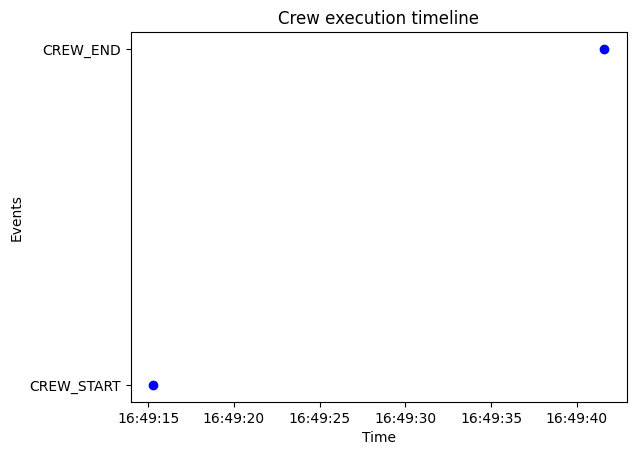

In [151]:
import matplotlib.pyplot as plt
times = [datetime.fromisoformat(log['timestamp']) for log in observer.logs]
events = [log['event_type'] for log in observer.logs]

plt.scatter(times, range(len(events)), c='blue')
plt.yticks(range(len(events)), events)
plt.title("Crew execution timeline")
plt.xlabel("Time")
plt.ylabel("Events")
plt.show()

## 🎉 Congratulations!

You've completed the CrewAI practice notebook! You've learned:

✅ How to create custom tools for agents  
✅ How to implement MCP-style tools for external integrations  
✅ How to configure and use Gemini 2.5 Flash model  
✅ How to create specialized agents with specific roles  
✅ How to define and orchestrate tasks  
✅ How to implement observability and monitoring  
✅ How to export and analyze execution logs  

### 🔗 Useful Resources:

- [CrewAI Documentation](https://docs.crewai.com/)
- [Google AI Studio](https://makersuite.google.com/)
- [LangChain Tools](https://python.langchain.com/docs/modules/agents/tools/)

Happy coding! 🚀🎬